<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [299]:
# system library
import os
import sys
import json
import pickle
import datetime
import calendar
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Datasets loading </h6>

In [300]:
df = pd.read_csv('../../data/fma_metadata/group_20_fma.csv', index_col=0)
tracks = pd.read_csv('../../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
print(df.shape)

(103708, 44)


<h6>Recompose track_date_created column</h6>

In [301]:
date_created_column = pd.to_datetime(tracks[('track', 'date_created')], format='%Y%m', errors='ignore').astype('datetime64[ns]')
track_date_created_year_index = df.columns.get_loc("track_date_created_year")
track_date_created_season_index = df.columns.get_loc("track_date_created_season")

In [302]:
df.insert(track_date_created_year_index, 'track_date_created', date_created_column)
del df["track_date_created_year"]
del df["track_date_created_season"]

<h2> Created Counter based uppon years, months, weeks, days and hours</h2>

Track creation spans between **2008-11-25 17:49:06** and **2017-03-30 15:23:39**, so we will differenciate between the following datetime divisions:

- 10 years;
- 101 months;
- 435 weeks;
- 3.048 days;
- 73.125 hours (73.126 approximated);
- 36 seasons;
- 202 weekdays;
- 202 daymoments.

where weekdays and daymoments are approximated to monthly "Workday" and "Weekend" and "Day" and "Night" counting, respectively.

In [303]:
def translate_x(x, remapping_dict):
    keys = list(remapping_dict.keys())
    values = list(remapping_dict.values())

    x_translated = []
    for plot_index in x:
        key_index = values.index(plot_index)
        translation = keys[key_index]
        x_translated.append(translation)
    return x_translated

In [304]:
def studio_and_live_recording_years_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    delta = (end.year - start.year) 
    # print('years between start and end:', delta)

    # encode years as contigous integers 
    i = 0
    years_remapping_dict = {}
    while(start.year <= end.year):
        years_remapping_dict[start.year] = i 
        i += 1
        start += relativedelta(years=1) 
    
    # Studio and Live recording track_listens counting based uppon years
    x = list(years_remapping_dict.values())
    y1 = [0]*(len(years_remapping_dict))
    y2 = [0]*(len(years_remapping_dict))
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type  
        l = row.track_listens

        index = years_remapping_dict[d.year] 

        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l

    return x, years_remapping_dict, y1, y2

In [305]:
def studio_and_live_recording_months_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    num_months = (end.year - start.year) * 12 + (end.month - start.month)
    # print('months between start and end:', num_months + 2) # counting start and end months

    start_month = pd.Timestamp(start.year, start.month, 1)
    end_month = pd.Timestamp(end.year, end.month, 1)
    if end_month <= end:  # check if we omitted end
        end_month = pd.Timestamp(end.year, end.month + 1, 1)

    # encode yearly months as contigous integers 
    i = 0
    weeks_remapping_dict = {}
    while(start_month <= end_month):
        weeks_remapping_dict[start_month.year, start_month.month] = i 
        i += 1
        start_month = start_month + relativedelta(months=+1)  # updating month
    
    # Studio and Live recording frequency counting based uppon months
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(weeks_remapping_dict))
    y2 = [0]*(len(weeks_remapping_dict))
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type  
        l = row.track_listens

        index = weeks_remapping_dict[d.year, d.month] 

        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l

    return x, weeks_remapping_dict, y1, y2

In [306]:
def get_season_from_month(month):
    if month == 3 or month == 4 or month == 5:
        return "Spring"
    if month == 6 or month == 7 or month == 8:
        return "Summer"
    if month == 9 or month == 10 or month == 11:
        return "Autumn"
    if month == 12 or month == 1 or month == 2:
        return "Winter"
    print("Wrong month=%s" % month)
    sys.exit(-1)

In [307]:
def studio_and_live_recording_seasons_timeframe(external_df):
    _, tmp_weeks_remapping_dict, _, _ = studio_and_live_recording_months_timeframe(external_df)
    
    # encode yearly seasons as contigous integers 
    i = 0
    elem_list = set()
    weeks_remapping_dict = {}
    for year, month in tmp_weeks_remapping_dict.keys():
        season = get_season_from_month(month)
        key = year, season
        if key not in elem_list:
            weeks_remapping_dict[key] = i
            elem_list.add(key)
            i += 1
        
    # Studio and Live recording frequency counting based uppon seasons
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(x))
    y2 = [0]*(len(x))
    
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type  
        l = row.track_listens
        d_season = get_season_from_month(d.month)

        index = weeks_remapping_dict[d.year, d_season] 
        
        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l

    return x, weeks_remapping_dict, y1, y2

In [308]:
def studio_and_live_recording_weeks_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    monday1 = (start - timedelta(days=start.weekday())).date()
    monday2 = (end - timedelta(days=end.weekday())).date()
    # print('weeks between start and end:', round((monday2 - monday1).days / 7)) 

    # encode yearly weeks as contigous integers 
    i = 0
    weeks_remapping_dict = {}
    while(monday1 <= monday2):
        weeks_remapping_dict[monday1] = i 
        i += 1
        monday1 += timedelta(days=7)  # updating week
    # adding last week
    weeks_remapping_dict[monday1] = i

    # Studio and Live recording frequency counting based uppon year's weeks 
    x = list(weeks_remapping_dict.values())
    y1 = [0]*(len(weeks_remapping_dict))
    y2 = [0]*(len(weeks_remapping_dict))
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type  
        l = row.track_listens
        d_monday = (d - timedelta(days=d.weekday())).date()  # retrieve week's monday

        index = weeks_remapping_dict[d_monday] 

        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l

    return x, weeks_remapping_dict, y1, y2

In [309]:
def studio_and_live_recording_days_timeframe(external_df):

    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    delta = end - start
    # print('days between start and end:', delta.days + 2)  

    # encode yearly days as contigous integers 
    days_remapping_dict = {}
    for i in range(0, delta.days + 2):  # adding 2 extra days to contemplate end
        day = start + timedelta(days=i)
        key = day.year, day.month, day.day
        days_remapping_dict[key] = i 

    # Studio and Live recording frequency counting based uppon year's and month's day 
    x = list(days_remapping_dict.values())
    y1 = [0]*(len(days_remapping_dict))
    y2 = [0]*(len(days_remapping_dict))
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        l = row.track_listens
        key = d.year, d.month, d.day

        index = days_remapping_dict[key] 

        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l
            
    return x, days_remapping_dict, y1, y2

In [310]:
def get_weekday_from_day(year, month, day):
    my_date = datetime.date(year, month, day)
    week_day =  calendar.day_name[my_date.weekday()]
    
    if week_day == "Saturday" or week_day == "Sunday":
        return "Weekend"
    else:
        return "Workday"

In [311]:
def studio_and_live_recording_weekdays_timeframe(external_df):
    _, tmp_days_remapping_dict, _, _ = studio_and_live_recording_days_timeframe(external_df)
    
    # encode yearly weekdays as contigous integers 
    i = 0
    elem_list = set()
    days_remapping_dict = {}
    for year, month, day in tmp_days_remapping_dict.keys():
        weekday = get_weekday_from_day(year, month, day)
        key = year, month, weekday
        if key not in elem_list:
            days_remapping_dict[key] = i
            elem_list.add(key)
            i += 1

    # Studio and Live recording frequency counting based uppon year's and month's day 
    x = list(days_remapping_dict.values())
    y1 = [0]*(len(days_remapping_dict))
    y2 = [0]*(len(days_remapping_dict))
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        l = row.track_listens
        weekday = get_weekday_from_day(d.year, d.month, d.day)
        key = d.year, d.month, weekday

        index = days_remapping_dict[key] 

        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l
            
    return x, days_remapping_dict, y1, y2

In [312]:
def studio_and_live_recording_hours_timeframe(external_df):
    start = external_df['track_date_created'].min()
    end = external_df['track_date_created'].max()
    delta = end - start

    days = []
    for i in range(0, delta.days + 2):
        day = start + timedelta(days=i)
        key = (day.year, day.month, day.day)
        days.append(key)

    ddays, seconds = delta.days, delta.seconds
    hours = ddays * 24 + seconds // 3600
    # print('hours between start and end:', hours)  
   
    # encode yearly hours as contigous integers 
    i = 0
    hours_remapping_dict = {}
    for d in days:
        for h in range(0, 24):
            key = d[0], d[1], d[2], h
            hours_remapping_dict[key] = i
            i += 1
          
    # Studio and Live recording frequency counting based uppon year's and day's hours
    x = list(hours_remapping_dict.values())
    y1 = [0]*(len(hours_remapping_dict))
    y2 = [0]*(len(hours_remapping_dict))
    
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        l = row.track_listens
        key = d.year, d.month, d.day, d.hour

        index = hours_remapping_dict[key] 
        
        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l
        
    return x, hours_remapping_dict, y1, y2

In [313]:
def get_daymoment_from_hour(hour):
    if (hour >= 19 and hour <= 23) or (hour >= 0 and hour < 7):
        return "Night"
    if (hour >= 7 and hour < 19):
        return "Day"
    print("Wrong hour=%s" % hour)

In [314]:
def studio_and_live_recording_daymoments_timeframe(external_df):
    _, tmp_hours_remapping_dict, _, _ = studio_and_live_recording_hours_timeframe(external_df)
    
    # encode yearly daymoments as contigous integers 
    i = 0
    elem_list = set()
    hours_remapping_dict = {}
    for year, month, day, hour in tmp_hours_remapping_dict.keys():
        daymoment = get_daymoment_from_hour(hour)
        key = year, month, daymoment
        if key not in elem_list:
            hours_remapping_dict[key] = i
            elem_list.add(key)
            i += 1
          
    # Studio and Live recording frequency counting based uppon year's and day's hours
    x = list(hours_remapping_dict.values())
    y1 = [0]*(len(hours_remapping_dict))
    y2 = [0]*(len(hours_remapping_dict))
    
    for row in external_df[["track_date_created", "album_type", "track_listens"]].itertuples():
        d = row.track_date_created
        a = row.album_type
        l = row.track_listens
        d_daymoment = get_daymoment_from_hour(d.hour)
        key = d.year, d.month, d_daymoment

        index = hours_remapping_dict[key] 
        
        if a == "Studio Recording":
            y1[index] += l
        elif a == "Live Recording":
            y2[index] += l
        
    return x, hours_remapping_dict, y1, y2

In [315]:
def plot_TS_based_uppon_track_listens(external_df, target_flag, track_date_created_sub_info, log_flag):
    
    if track_date_created_sub_info == "years":
        x, x_map, y1, y2 = studio_and_live_recording_years_timeframe(external_df)
    elif track_date_created_sub_info == "months":
        x, x_map, y1, y2 = studio_and_live_recording_months_timeframe(external_df)
    elif track_date_created_sub_info == "weeks":
        x, x_map, y1, y2 =  studio_and_live_recording_weeks_timeframe(external_df)
    elif track_date_created_sub_info == "days":
        x, x_map, y1, y2 =  studio_and_live_recording_days_timeframe(external_df)
    elif track_date_created_sub_info == "hours":
        x, x_map, y1, y2 = studio_and_live_recording_hours_timeframe(external_df)
    elif track_date_created_sub_info == "seasons":
        x, x_map, y1, y2 = studio_and_live_recording_seasons_timeframe(external_df)
    elif track_date_created_sub_info == "weekdays":
        x, x_map, y1, y2 = studio_and_live_recording_weekdays_timeframe(external_df)
    elif track_date_created_sub_info == "daymoments":
        x, x_map, y1, y2 = studio_and_live_recording_daymoments_timeframe(external_df)
    else:
        print("wrong track_date_created_sub_info=%s" % track_date_created_sub_info)
        sys.exit(-1)

    fig, ax = plt.subplots(figsize=(8, 5))
    if target_flag == "":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
        sns.lineplot(x=x, y=y2, label="Live Recoridng")
    elif target_flag == "Studio Recording":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
    elif target_flag == "Live Recording":
        sns.lineplot(x=x, y=y2, label="Live Recoridng", color="mediumseagreen")
    
    if track_date_created_sub_info == "years":
        plt.xlim(0, 9)
        ax.set_xticklabels(list(x_map.keys()))
    if log_flag:
        plt.yscale("log")
    ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
    plt.xlabel(track_date_created_sub_info)
    plt.ylabel("track_listens")
    plt.legend(title="album_type", loc="best")
    plt.title("Album type's frequency per %s" % track_date_created_sub_info)
    plt.show()

In [344]:
def plot_TS(external_df, target_flag, track_date_created_sub_info, log_flag, x, y1, y2):
    fig, ax = plt.subplots(figsize=(8, 5))
    if target_flag == "":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
        sns.lineplot(x=x, y=y2, label="Live Recoridng")
    elif target_flag == "Studio Recording":
        sns.lineplot(x=x, y=y1, label="Studio Recoridng")
    elif target_flag == "Live Recording":
        sns.lineplot(x=x, y=y2, label="Live Recoridng", color="mediumseagreen")
    
    if track_date_created_sub_info == "years":
        plt.xlim(0, 9)
        ax.set_xticklabels([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
    if log_flag:
        plt.yscale("log")
    ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
    plt.xlabel(track_date_created_sub_info)
    plt.ylabel("track_listens")
    plt.legend(title="album_type", loc="best")
    plt.title("Album type's frequency per %s" % track_date_created_sub_info)
    plt.show()

<h6>Years insight</h6>

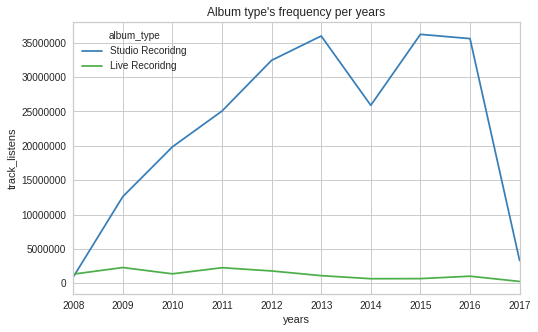

In [317]:
plot_TS_based_uppon_track_listens(df, "", "years", False)

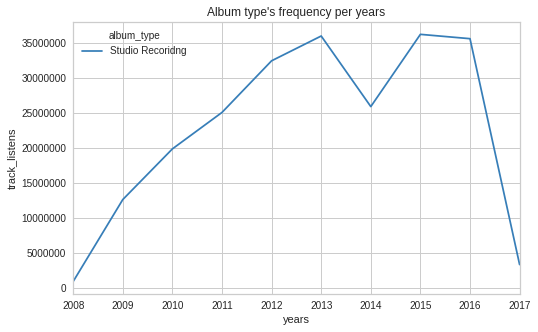

In [318]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "years", False)

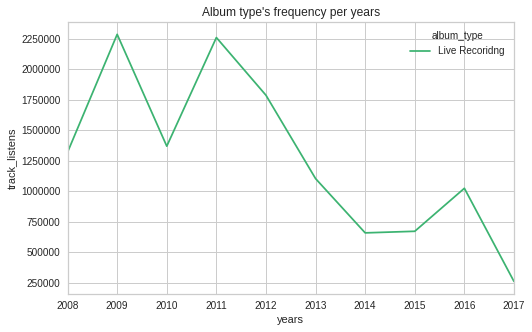

In [319]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "years", False)

<h6> Months insight </h6>

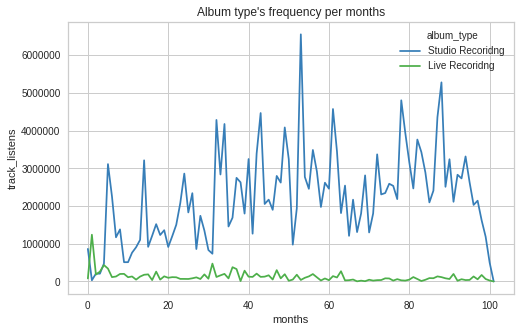

In [320]:
plot_TS_based_uppon_track_listens(df, "", "months", False)

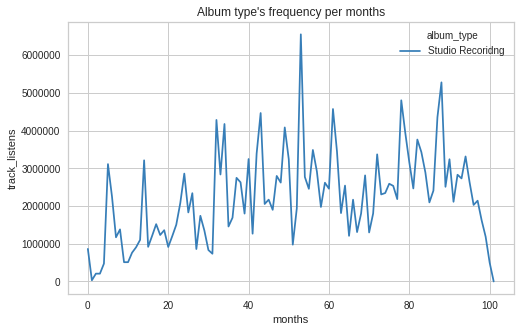

In [321]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "months", False)

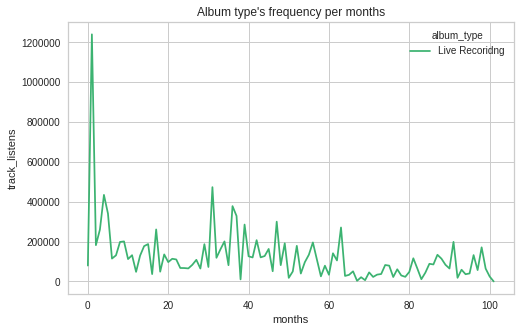

In [322]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "months", False)

<h6> Weeks insight </h6> 

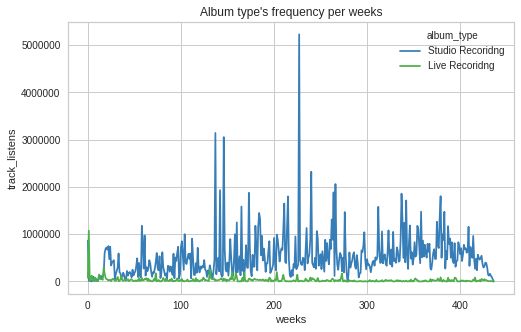

In [323]:
plot_TS_based_uppon_track_listens(df, "", "weeks", False)

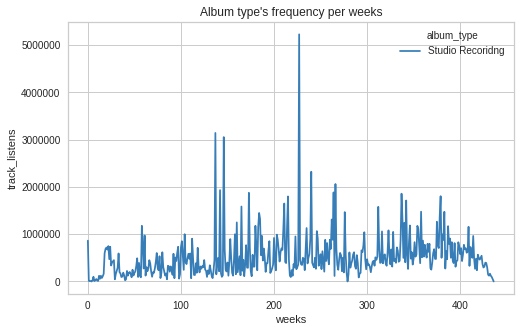

In [324]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "weeks", False)

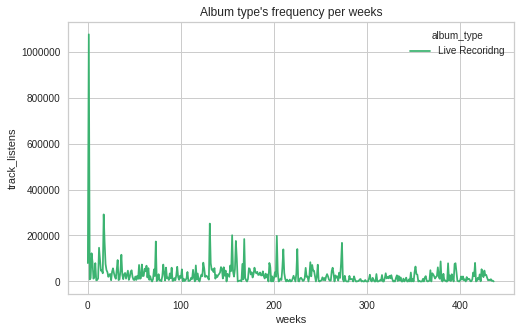

In [325]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "weeks", False)

<h6> Days insight </h6>

<b><font color="red"> Preferable to use Workday and Weekend yearly, monthly sliding window </font></b>

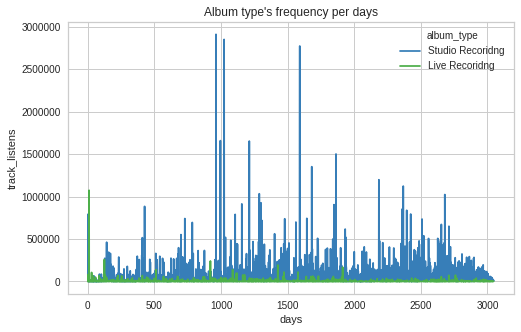

In [326]:
plot_TS_based_uppon_track_listens(df, "", "days", False)

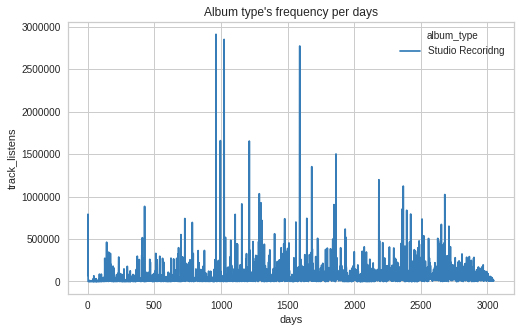

In [327]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "days", False)

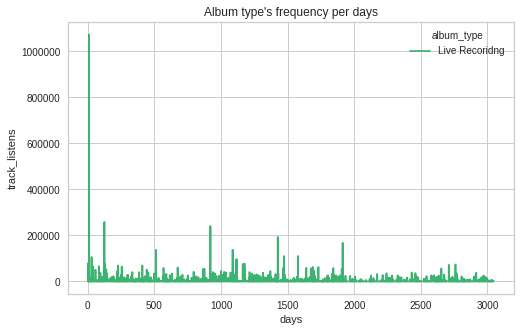

In [328]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "days", False)

<h6>Hours insight </h6>

<b><font color="red"> Preferable to use Day and Night yearly, monthly sliding window </font></b>

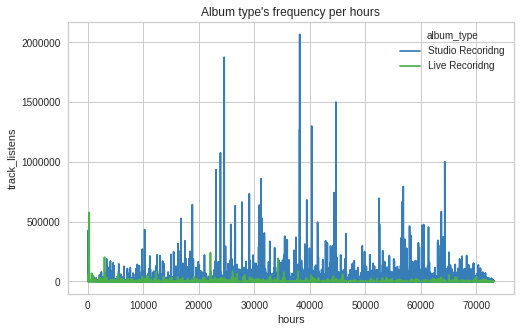

In [329]:
plot_TS_based_uppon_track_listens(df, "", "hours", False)

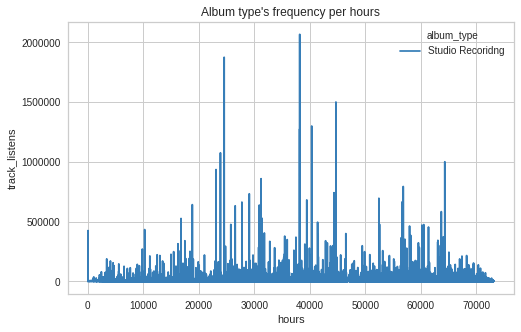

In [330]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "hours", False)

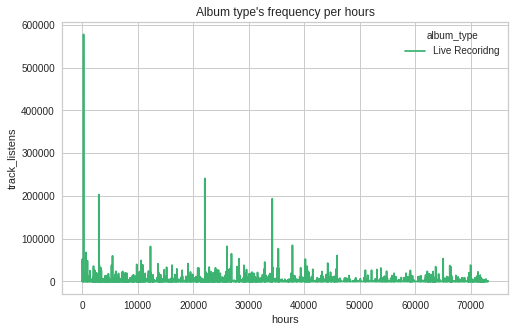

In [331]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "hours", False)

<h6>Season insight </h6>

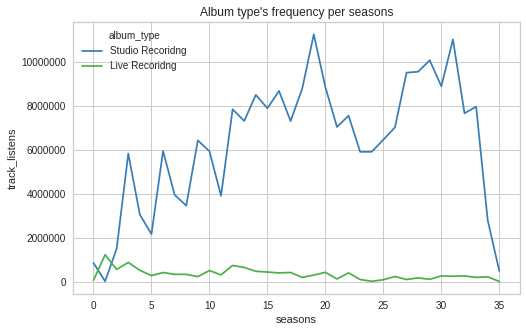

In [332]:
plot_TS_based_uppon_track_listens(df, "", "seasons", False)

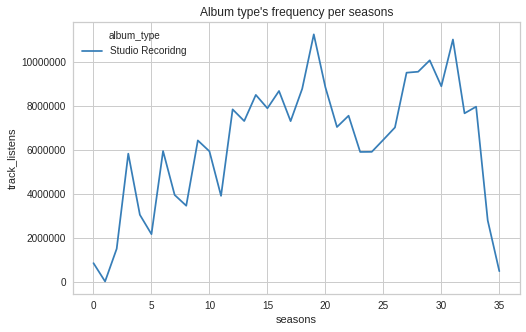

In [333]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "seasons", False)

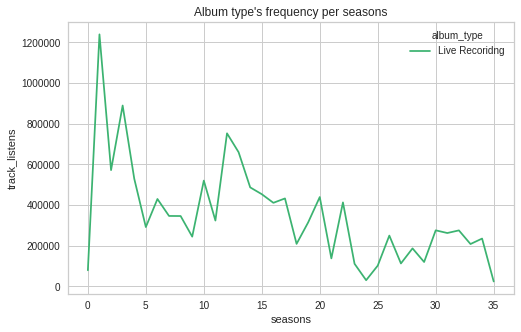

In [334]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "seasons", False)

<h6>Weekdays insight </h6>

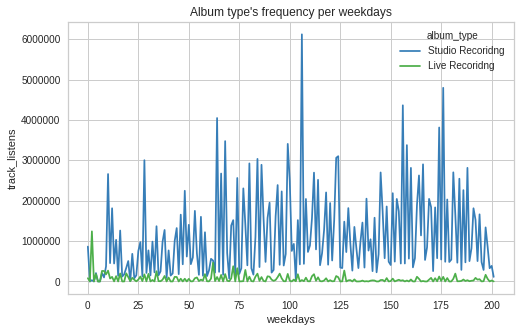

In [335]:
plot_TS_based_uppon_track_listens(df, "", "weekdays", False)

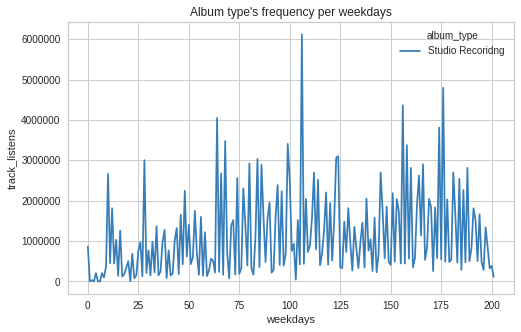

In [336]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "weekdays", False)

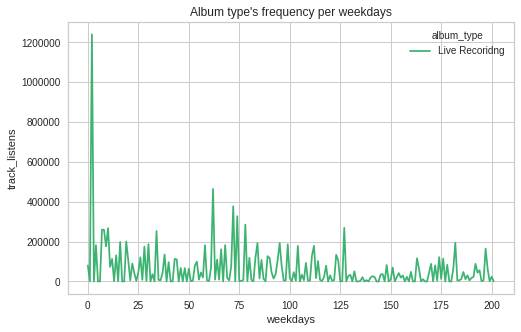

In [337]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "weekdays", False)

<h6> Daymoments insight </h6>

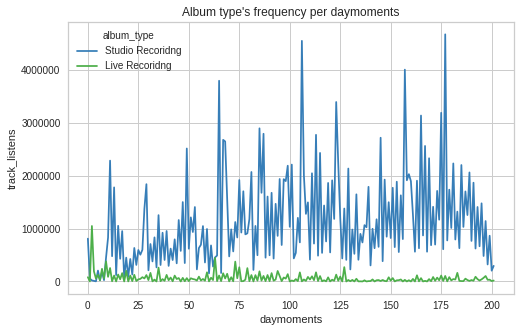

In [338]:
plot_TS_based_uppon_track_listens(df, "", "daymoments", False)

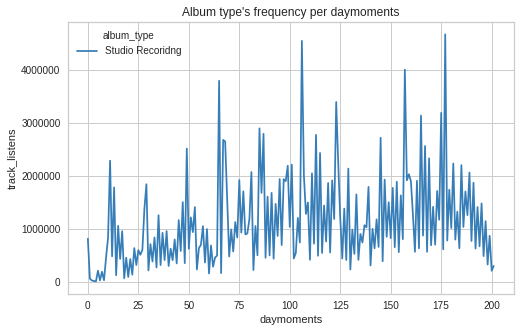

In [339]:
plot_TS_based_uppon_track_listens(df, "Studio Recording", "daymoments", False)

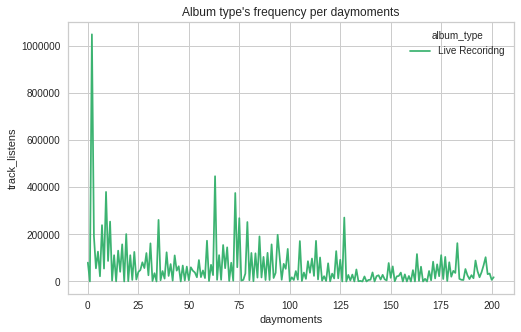

In [340]:
plot_TS_based_uppon_track_listens(df, "Live Recording", "daymoments", False)

<h2> Saving TS ad DataFrames </h6>

In [342]:
def build_TS_dataframe2(external_df, track_date_created_sub_info):
    
    if track_date_created_sub_info == "years":
        x, x_map, y1, y2 = studio_and_live_recording_years_timeframe(df)
    elif track_date_created_sub_info == "months":
        x, x_map, y1, y2 = studio_and_live_recording_months_timeframe(df)
    elif track_date_created_sub_info == "weeks":
        x, x_map, y1, y2 =  studio_and_live_recording_weeks_timeframe(df)
    elif track_date_created_sub_info == "days":
        pass
    elif track_date_created_sub_info == "hours":
        pass
    elif track_date_created_sub_info == "seasons":
        x, x_map, y1, y2 = studio_and_live_recording_seasons_timeframe(df)
    elif track_date_created_sub_info == "weekdays":
        x, x_map, y1, y2 = studio_and_live_recording_weekdays_timeframe(df)
    elif track_date_created_sub_info == "daymoments":
        x, x_map, y1, y2 = studio_and_live_recording_daymoments_timeframe(df)
    
    x_translated = translate_x(x, x_map)

    dict_ts = {}
    dict_ts["x"] = x
    dict_ts["y1"] = y1
    dict_ts["y2"] = y2
    dict_ts["x_map"] = x_map
    dict_ts["x_translated"] = x_translated
    
    return dict_ts

In [343]:
TSs = ["years", "months", "weeks", "seasons", "weekdays", "daymoments"]  # N.B. omitting "days" and "hours"

for track_date_created_sub_info in TSs:
    dict_ts = build_TS_dataframe2(df, track_date_created_sub_info)
    filename = '../../data/fma_metadata/' + track_date_created_sub_info + '_track_listens.pickle'
    with open(filename, 'wb') as fp:
        pickle.dump(dict_ts, fp, protocol=pickle.HIGHEST_PROTOCOL)